# Import

In [115]:
import torch
import os
import os
import glob
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import numpy as np
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from PIL import Image
import pandas as pd
from sklearn.model_selection import train_test_split
import time
import matplotlib.pyplot as plt


# deal with images

In [116]:
def parse_pairs_file(file_path):
    pairs = []
    with open(file_path, 'r') as f:
        lines = f.readlines()[1:]  # Skip the header
        for line in lines:
            parts = line.strip().split()
            if len(parts) == 3:
                person = parts[0]
                img1 = f"{person}_{int(parts[1]):04d}.jpg"
                img2 = f"{person}_{int(parts[2]):04d}.jpg"
                pairs.append((person, img1, person, img2))  # Unified tuple format
            elif len(parts) == 4:
                person1 = parts[0]
                img1 = f"{person1}_{int(parts[1]):04d}.jpg"
                person2 = parts[2]
                img2 = f"{person2}_{int(parts[3]):04d}.jpg"
                pairs.append((person1, img1, person2, img2))
    return pairs

def process_and_save_image(src_path, dest_path, size=(250, 250)):
    """
    Processes a single image: converts to grayscale, resizes, normalizes, and saves.
    """
    if not os.path.exists(src_path):
        print(f"Warning: File {src_path} not found.")
        return
    img = Image.open(src_path).convert('L')  # Convert to grayscale
    transform = transforms.Compose([
        transforms.Resize(size),
        transforms.ToTensor()
    ])
    tensor = transform(img)

    # Convert tensor back to PIL image for saving
    inv_transform = transforms.Compose([
        #transforms.Normalize(mean=[-1], std=[2]),  # Inverse normalization for single channel
        transforms.ToPILImage()
    ])
    processed_img = inv_transform(tensor)
    processed_img.save(dest_path)

def ensure_directory(directory_path):
    """
    Ensures that a directory exists; if not, it creates it.
    """
    os.makedirs(directory_path, exist_ok=True)

def copy_pairs_to_directory(pairs, src_folder, dest_folder):
    """
    Processes and copies image pairs into the destination folder.
    Handles both same-person and different-person pairs.
    """
    for person1, img1, person2, img2 in pairs:
        # Prepare paths for the first person's image
        person1_folder = os.path.join(dest_folder, person1)
        ensure_directory(person1_folder)
        src_path1 = os.path.join(src_folder, person1, img1)
        dest_path1 = os.path.join(person1_folder, img1)
        process_and_save_image(src_path1, dest_path1)

        # Prepare paths for the second person's image
        person2_folder = os.path.join(dest_folder, person2)
        ensure_directory(person2_folder)
        src_path2 = os.path.join(src_folder, person2, img2)
        dest_path2 = os.path.join(person2_folder, img2)
        process_and_save_image(src_path2, dest_path2)

In [117]:
# File paths
src_folder = "/home/tak/justice-tal/lfw2/lfw2"
train_pairs_file = '/home/tak/justice-tal/pairsDevTrain.txt'
test_pairs_file = '/home/tak/justice-tal/pairsDevTest.txt'
train_dest_folder = '/home/tak/justice-tal/train'
test_dest_folder = '/home/tak/justice-tal/test'

# Parse pairs files
train_pairs = parse_pairs_file(train_pairs_file)
test_pairs = parse_pairs_file(test_pairs_file)

# Process and copy pairs
print("Processing training pairs...")
copy_pairs_to_directory(train_pairs, src_folder, train_dest_folder)

print("Processing testing pairs...")
copy_pairs_to_directory(test_pairs, src_folder, test_dest_folder)

print("Processing complete.")

Processing training pairs...


Processing testing pairs...
Processing complete.


# load data

In [118]:
class LFWDataset(Dataset):
    """
    A dataset class for loading LFW image pairs.

    Args:
        pairs (list): List of tuples representing image pairs.
        base_folder (str): Base directory containing the images.
        transform (callable, optional): Optional transform to be applied on a sample.

    Methods:
        __len__(): Returns the number of image pairs.
        __getitem__(idx): Returns a tuple of two images and a label.
    """
    def __init__(self, pairs, base_folder, transform=None):
        self.pairs = pairs
        self.base_folder = base_folder
        self.transform = transform or self.default_transform()

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        try:
            pair = self.pairs[idx]
            label = 1 if pair[0] == pair[2] else 0  # Same person: 1, Different person: 0

            # Unified path logic for same and different pairs
            img1_path = os.path.join(self.base_folder, pair[0], pair[1])
            img2_path = os.path.join(self.base_folder, pair[2], pair[3])

            img1 = Image.open(img1_path).convert('L')
            img2 = Image.open(img2_path).convert('L')

            # Apply transformations
            if self.transform:
                img1 = self.transform(img1)
                img2 = self.transform(img2)

            return img1, img2, torch.tensor(label, dtype=torch.float32)

        except Exception as e:
            print(f"Error loading pair {self.pairs[idx]}: {e}")
            return None

    @staticmethod
    def default_transform():
        """
        Default transformation for images: Grayscale, Resize, Normalize.
        """
        return transforms.Compose([
            transforms.Grayscale(num_output_channels=1),
            transforms.Resize((250, 250)),
            transforms.ToTensor(),
            transforms.Normalize((0.5,), (0.5,)),
        ])


def load_data(pairs, base_folder, batch_size=64, shuffle=True):
    """
    Utility function to create DataLoader from LFWDataset.

    Args:
        pairs (list): List of image pairs.
        base_folder (str): Path to the base folder containing images.
        batch_size (int): Batch size for DataLoader.
        shuffle (bool): Whether to shuffle the dataset.

    Returns:
        DataLoader: Torch DataLoader for the dataset.
    """
    dataset = LFWDataset(pairs, base_folder)
    # Filter out None values if any error occurs during dataset loading
    valid_pairs = [item for item in dataset if item is not None]
    return DataLoader(valid_pairs, batch_size=batch_size, shuffle=shuffle)


# EX1

In [119]:
results = []

## bacth size 32

In [120]:
# Paths
train_dest_folder = '/home/tak/justice-tal//train'
test_dest_folder = '/home/tak/justice-tal/test'

# Split train pairs into training and validation sets
train_pairs, val_pairs = train_test_split(train_pairs, test_size=0.2, random_state=42)

# Define DataLoader for training, validation, and testing
batch_size = 32

print("Loading training data...")
train_loader = load_data(train_pairs, train_dest_folder, batch_size=batch_size, shuffle=True)

print("Loading validation data...")
val_loader = load_data(val_pairs, train_dest_folder, batch_size=batch_size, shuffle=False)

print("Loading testing data...")
test_loader = load_data(test_pairs, test_dest_folder, batch_size=batch_size, shuffle=False)

print("Data loaders created successfully.")


Loading training data...


Loading validation data...
Loading testing data...
Data loaders created successfully.


## network - no batchnorm

In [121]:
class SiameseNetwork(nn.Module):
    """
    Siamese Network for one-shot learning on face recognition.

    This architecture is based on the model presented in the academic paper provided in the assignment.

    Network Architecture:
        - Convolutional layers with Batch Normalization and ReLU activation
        - MaxPooling layers for downsampling
        - Fully connected layers to transform the feature maps into a single vector
        - The network outputs the probability that the two input images belong to the same person

    Methods:
        forward(input1, input2): Performs the forward pass for a pair of input images.
        forward_through(x): Helper function to pass input through the CNN and FC layers.
    """
    def __init__(self):
        super(SiameseNetwork, self).__init__()

        # CNN architecture
        self.cnn = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=25, stride=1, padding=0),
            # nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, stride=2),
            nn.Conv2d(64, 128, kernel_size=18, stride=1, padding=0),
            # nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, stride=2),
            nn.Conv2d(128, 128, kernel_size=10, stride=1, padding=0),
            # nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, stride=2),
            nn.Conv2d(128, 256, kernel_size=10, stride=1, padding=0),
            # nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Flatten()
        )

        # Fully connected layers
        self.fc1 =  nn.Linear(256 * 10 * 10, 4096)
        self.fc2 = nn.Linear(4096, 1)

    def forward(self, input1, input2):
        """
        Forward pass for both inputs through the same CNN and FC layers.

        Args:
            input1 (torch.Tensor): The first input image.
            input2 (torch.Tensor): The second input image.

        Returns:
            torch.Tensor: The probability that the two input images are of the same person.
        """
        output1 = self.forward_through(input1)
        output2 = self.forward_through(input2)

        # Calculate the absolute difference between the feature representations
        diff_features = torch.abs(output1 - output2)
        output = self.fc2(diff_features)
        return torch.sigmoid(output)  # Apply sigmoid here to output a probability between 0 and 1

    def forward_through(self, x):
        """
        Helper function to propagate the input through the CNN and FC layers.

        Args:
            x (torch.Tensor): The input image.

        Returns:
            torch.Tensor: The output feature vector from the fully connected layer.
        """
        x = self.cnn(x)
        x = x.view(x.size(0), -1)  # Flatten the output to match the input needs of the FC layer
        x = self.fc1(x)  # Pass through the first fully connected layer
        return torch.sigmoid(x)


## train - SGD

In [122]:
from tqdm import tqdm
from sklearn.metrics import precision_recall_curve, roc_curve, f1_score

def find_best_threshold(y_true, y_scores):
    """
    Finds the best threshold based on F1 Score.

    Args:
        y_true: Ground truth labels (0 or 1).
        y_scores: Model predictions (probabilities).

    Returns:
        best_threshold: Threshold that maximizes the F1 Score.
    """
    thresholds = np.linspace(0, 1, 100)  # Generate thresholds from 0 to 1
    best_threshold = 0.5  # Default threshold
    best_accuracy = 0

    for threshold in thresholds:
        y_pred = (y_scores >= threshold).astype(int)  # Convert probabilities to binary predictions
        accuracy = (y_pred == y_true).mean()  # Compute accuracy
        
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_threshold = threshold

    return best_threshold


def train(model, train_loader, val_loader, device, num_epochs=10, optimizer_type='Adam', lr=0.001, patience=5):
    if optimizer_type == 'Adam':
        optimizer = optim.Adam(model.parameters(), lr=lr)
    elif optimizer_type == 'SGD':
        optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9,weight_decay=1e-4)
    else:
        raise ValueError("Unsupported optimizer type")

    criterion = nn.BCELoss()

    scheduler = StepLR(optimizer, step_size=7, gamma=0.1)

    model.to(device)

    best_val_loss = float('inf')
    patience_counter = 0

    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    for epoch in range(num_epochs):
        model.train()
        train_loss, train_correct, train_total = 0, 0, 0

        for data in train_loader:
            img1, img2, labels = data
            img1, img2, labels = img1.to(device), img2.to(device), labels.to(device).float()
            labels = labels.unsqueeze(1)

            optimizer.zero_grad()
            outputs = model(img1, img2)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            predicted = outputs > find_best_threshold(labels.detach().cpu().numpy(), outputs.detach().cpu().numpy())
            train_correct += (predicted == labels).sum().item()
            train_total += labels.size(0)

        avg_train_loss = train_loss / len(train_loader)
        train_accuracy = 100 * train_correct / train_total
        train_losses.append(avg_train_loss)
        train_accuracies.append(train_accuracy)

        model.eval()
        val_loss, val_correct, val_total = 0, 0, 0
        with torch.no_grad():
            for data in val_loader:
                img1, img2, labels = data
                labels = labels.unsqueeze(1)
                img1, img2, labels = img1.to(device), img2.to(device), labels.to(device).float()

                outputs = model(img1, img2)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                predicted = outputs > find_best_threshold(labels.detach().cpu().numpy(), outputs.detach().cpu().numpy())
                val_correct += (predicted == labels).sum().item()
                val_total += labels.size(0)

        avg_val_loss = val_loss / len(val_loader)
        val_accuracy = 100 * val_correct / val_total
        val_losses.append(avg_val_loss)
        val_accuracies.append(val_accuracy)

        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Train Acc: {train_accuracy:.2f}%')
        print(f'Validation Loss: {avg_val_loss:.4f}, Validation Acc: {val_accuracy:.2f}%')

        # Learning rate scheduling
        scheduler.step()

        # Early stopping
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            patience_counter = 0
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print(f'Early stopping triggered after {epoch+1} epochs.')
            break

    return train_losses, train_accuracies, val_losses, val_accuracies, epoch+1

Epoch [1/15], Train Loss: 0.6932, Train Acc: 57.67%
Validation Loss: 0.6932, Validation Acc: 58.41%
Epoch [2/15], Train Loss: 0.6854, Train Acc: 65.23%
Validation Loss: 0.6607, Validation Acc: 70.68%
Epoch [3/15], Train Loss: 0.6477, Train Acc: 72.05%
Validation Loss: 0.6158, Validation Acc: 74.55%
Epoch [4/15], Train Loss: 0.6238, Train Acc: 73.64%
Validation Loss: 0.6423, Validation Acc: 72.05%
Epoch [5/15], Train Loss: 0.6163, Train Acc: 75.34%
Validation Loss: 0.5968, Validation Acc: 77.27%
Epoch [6/15], Train Loss: 0.5842, Train Acc: 76.48%
Validation Loss: 0.5750, Validation Acc: 76.82%
Epoch [7/15], Train Loss: 0.5548, Train Acc: 78.64%
Validation Loss: 0.5916, Validation Acc: 78.41%
Epoch [8/15], Train Loss: 0.5033, Train Acc: 81.99%
Validation Loss: 0.5596, Validation Acc: 77.50%
Epoch [9/15], Train Loss: 0.4531, Train Acc: 84.77%
Validation Loss: 0.5533, Validation Acc: 78.86%
Epoch [10/15], Train Loss: 0.4183, Train Acc: 87.16%
Validation Loss: 0.5579, Validation Acc: 77.73%

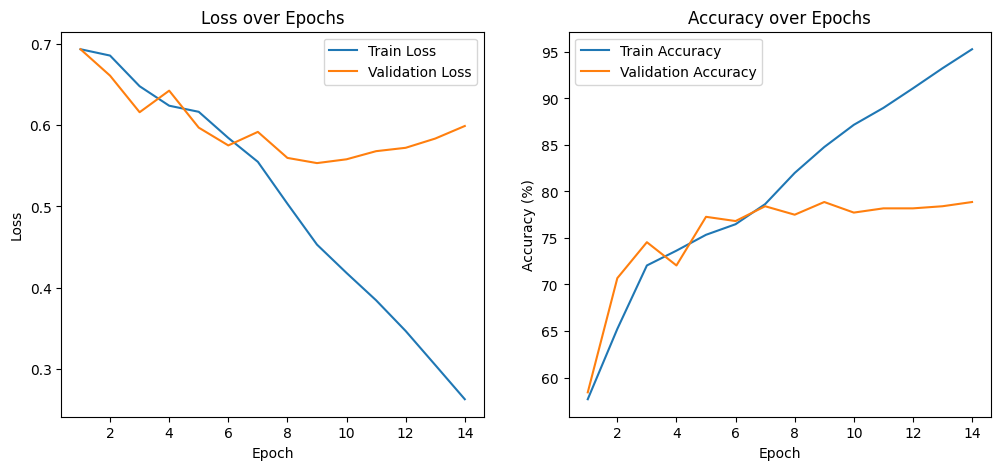

In [123]:
siamese_model = SiameseNetwork()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
num_epochs = 15
optimizer_type = 'SGD'
lr = 0.01
patience = 5
start_time = time.time()
train_losses, train_accuracies, val_losses, val_accuracies, epoch = train(siamese_model, train_loader, val_loader, device,
                                                                    num_epochs=num_epochs, optimizer_type=optimizer_type,
                                                                      lr=lr, patience=patience)
end_time = time.time()

epochs = range(1, len(train_losses) + 1)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss over Epochs')

plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label='Train Accuracy')
plt.plot(epochs, val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.title('Accuracy over Epochs')
plt.show()


Test Loss: 0.6633, Test Accuracy: 68.70%


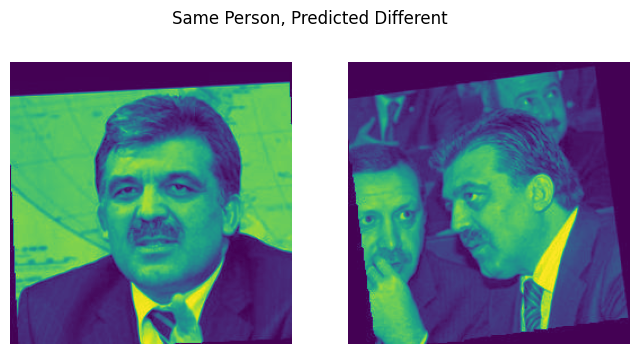

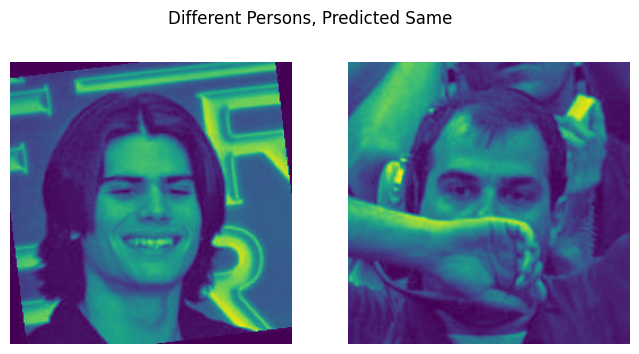

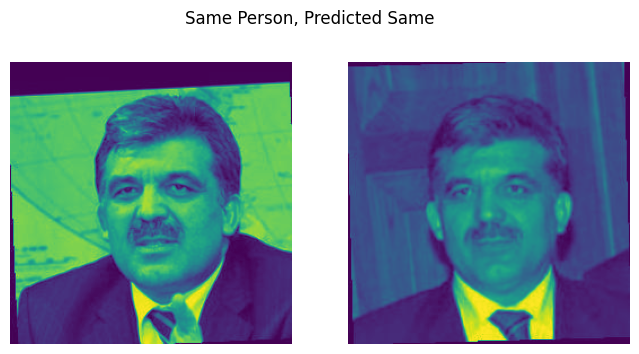

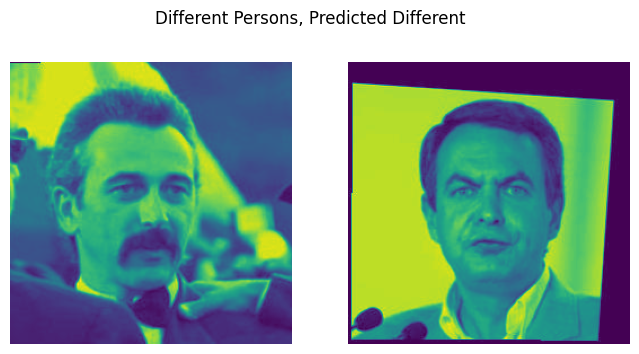

In [124]:
def show_images(img1, img2, title, figsize=(8, 4)):
    fig, axes = plt.subplots(1, 2, figsize=figsize)
    axes[0].imshow(img1.permute(1, 2, 0).cpu())
    axes[0].axis('off')
    axes[1].imshow(img2.permute(1, 2, 0).cpu())
    axes[1].axis('off')
    fig.suptitle(title)
    plt.show()

def test_with_visualization(model, test_loader, device):
    model.eval()
    test_loss, test_correct, test_total = 0, 0, 0
    criterion = nn.BCELoss()
    
    same_person_wrong = None
    diff_person_wrong = None
    same_person_right = None
    diff_person_right = None

    with torch.no_grad():
        for data in test_loader:
            img1, img2, labels = data
            labels = labels.unsqueeze(1)
            img1, img2, labels = img1.to(device), img2.to(device), labels.to(device).float()
            
            outputs = model(img1, img2)
            loss = criterion(outputs, labels)
            test_loss += loss.item()

            predicted = outputs > 0.5
            test_correct += (predicted == labels).sum().item()
            test_total += labels.size(0)
            
            for i in range(len(labels)):
                if predicted[i] and not labels[i]:  # Different persons predicted as same
                    if diff_person_wrong is None:
                        diff_person_wrong = (img1[i], img2[i])
                elif not predicted[i] and labels[i]:  # Same person predicted as different
                    if same_person_wrong is None:
                        same_person_wrong = (img1[i], img2[i])
                elif predicted[i] and labels[i]:  # Same person predicted as same
                    if same_person_right is None:
                        same_person_right = (img1[i], img2[i])
                elif not predicted[i] and not labels[i]:  # Different persons predicted as different
                    if diff_person_right is None:
                        diff_person_right = (img1[i], img2[i])

    avg_test_loss = test_loss / len(test_loader)
    test_accuracy = 100 * test_correct / test_total
    print(f'Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%')

    if same_person_wrong is not None:
        show_images(same_person_wrong[0], same_person_wrong[1], 'Same Person, Predicted Different')
    if diff_person_wrong is not None:
        show_images(diff_person_wrong[0], diff_person_wrong[1], 'Different Persons, Predicted Same')
    if same_person_right is not None:
        show_images(same_person_right[0], same_person_right[1], 'Same Person, Predicted Same')
    if diff_person_right is not None:
        show_images(diff_person_right[0], diff_person_right[1], 'Different Persons, Predicted Different')
    return avg_test_loss, test_accuracy

avg_test_loss, test_accuracy = test_with_visualization(siamese_model, test_loader, device)

In [125]:
results.append({
    'Num_Epochs': epoch,
    'batch_size': batch_size,
    'Optimizer': optimizer_type,
    'Learning_Rate': lr,
    'Time_Taken': end_time - start_time,
    'Train_Loss': sum(train_losses) / len(train_losses),
    'Train_Accuracy': sum(train_accuracies) / len(train_accuracies),
    'Val_Loss': sum(val_losses) / len(val_losses),
    'Val_Accuracy': sum(val_accuracies) / len(val_accuracies),
    'Test_Loss': avg_test_loss,
    'Test_Accuracy': test_accuracy,
})

# EX2

## bacth size 32

In [ ]:
# Paths
train_dest_folder = '/home/tak/justice-tal//train'
test_dest_folder = '/home/tak/justice-tal/test'

# Split train pairs into training and validation sets
train_pairs, val_pairs = train_test_split(train_pairs, test_size=0.2, random_state=42)

# Define DataLoader for training, validation, and testing
batch_size = 32

print("Loading training data...")
train_loader = load_data(train_pairs, train_dest_folder, batch_size=batch_size, shuffle=True)

print("Loading validation data...")
val_loader = load_data(val_pairs, train_dest_folder, batch_size=batch_size, shuffle=False)

print("Loading testing data...")
test_loader = load_data(test_pairs, test_dest_folder, batch_size=batch_size, shuffle=False)

print("Data loaders created successfully.")


Loading training data...
Loading validation data...


Loading testing data...
Data loaders created successfully.


## network - batchnorm

In [ ]:
class SiameseNetwork(nn.Module):
    """
    Siamese Network for one-shot learning on face recognition.

    This architecture is based on the model presented in the academic paper provided in the assignment.

    Network Architecture:
        - Convolutional layers with Batch Normalization and ReLU activation
        - MaxPooling layers for downsampling
        - Fully connected layers to transform the feature maps into a single vector
        - The network outputs the probability that the two input images belong to the same person

    Methods:
        forward(input1, input2): Performs the forward pass for a pair of input images.
        forward_through(x): Helper function to pass input through the CNN and FC layers.
    """
    def __init__(self):
        super(SiameseNetwork, self).__init__()

        # CNN architecture
        self.cnn = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=25, stride=1, padding=0),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, stride=2),
            nn.Conv2d(64, 128, kernel_size=18, stride=1, padding=0),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, stride=2),
            nn.Conv2d(128, 128, kernel_size=10, stride=1, padding=0),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, stride=2),
            nn.Conv2d(128, 256, kernel_size=10, stride=1, padding=0),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Flatten()
        )

        # Fully connected layers
        self.fc1 =  nn.Linear(256 * 10 * 10, 4096)
        self.fc2 = nn.Linear(4096, 1)

    def forward(self, input1, input2):
        """
        Forward pass for both inputs through the same CNN and FC layers.

        Args:
            input1 (torch.Tensor): The first input image.
            input2 (torch.Tensor): The second input image.

        Returns:
            torch.Tensor: The probability that the two input images are of the same person.
        """
        output1 = self.forward_through(input1)
        output2 = self.forward_through(input2)

        # Calculate the absolute difference between the feature representations
        diff_features = torch.abs(output1 - output2)
        output = self.fc2(diff_features)
        return torch.sigmoid(output)  # Apply sigmoid here to output a probability between 0 and 1

    def forward_through(self, x):
        """
        Helper function to propagate the input through the CNN and FC layers.

        Args:
            x (torch.Tensor): The input image.

        Returns:
            torch.Tensor: The output feature vector from the fully connected layer.
        """
        x = self.cnn(x)
        x = x.view(x.size(0), -1)  # Flatten the output to match the input needs of the FC layer
        x = self.fc1(x)  # Pass through the first fully connected layer
        return torch.sigmoid(x)


## train - SGD

In [ ]:
from tqdm import tqdm
from sklearn.metrics import precision_recall_curve, roc_curve, f1_score

def find_best_threshold(y_true, y_scores):
    """
    Finds the best threshold based on F1 Score.

    Args:
        y_true: Ground truth labels (0 or 1).
        y_scores: Model predictions (probabilities).

    Returns:
        best_threshold: Threshold that maximizes the F1 Score.
    """
    thresholds = np.linspace(0, 1, 100)  # Generate thresholds from 0 to 1
    best_threshold = 0.5  # Default threshold
    best_accuracy = 0

    for threshold in thresholds:
        y_pred = (y_scores >= threshold).astype(int)  # Convert probabilities to binary predictions
        accuracy = (y_pred == y_true).mean()  # Compute accuracy
        
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_threshold = threshold

    return best_threshold


def train(model, train_loader, val_loader, device, num_epochs=10, optimizer_type='Adam', lr=0.001, patience=5):
    if optimizer_type == 'Adam':
        optimizer = optim.Adam(model.parameters(), lr=lr)
    elif optimizer_type == 'SGD':
        optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=1e-4)
    else:
        raise ValueError("Unsupported optimizer type")

    criterion = nn.BCELoss()

    scheduler = StepLR(optimizer, step_size=7, gamma=0.1)

    model.to(device)

    best_val_loss = float('inf')
    patience_counter = 0

    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    for epoch in range(num_epochs):
        model.train()
        train_loss, train_correct, train_total = 0, 0, 0

        for data in train_loader:
            img1, img2, labels = data
            img1, img2, labels = img1.to(device), img2.to(device), labels.to(device).float()
            labels = labels.unsqueeze(1)

            optimizer.zero_grad()
            outputs = model(img1, img2)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            predicted = outputs > find_best_threshold(labels.detach().cpu().numpy(), outputs.detach().cpu().numpy())
            train_correct += (predicted == labels).sum().item()
            train_total += labels.size(0)

        avg_train_loss = train_loss / len(train_loader)
        train_accuracy = 100 * train_correct / train_total
        train_losses.append(avg_train_loss)
        train_accuracies.append(train_accuracy)

        model.eval()
        val_loss, val_correct, val_total = 0, 0, 0
        with torch.no_grad():
            for data in val_loader:
                img1, img2, labels = data
                labels = labels.unsqueeze(1)
                img1, img2, labels = img1.to(device), img2.to(device), labels.to(device).float()

                outputs = model(img1, img2)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                predicted = outputs > find_best_threshold(labels.detach().cpu().numpy(), outputs.detach().cpu().numpy())
                val_correct += (predicted == labels).sum().item()
                val_total += labels.size(0)

        avg_val_loss = val_loss / len(val_loader)
        val_accuracy = 100 * val_correct / val_total
        val_losses.append(avg_val_loss)
        val_accuracies.append(val_accuracy)

        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Train Acc: {train_accuracy:.2f}%')
        print(f'Validation Loss: {avg_val_loss:.4f}, Validation Acc: {val_accuracy:.2f}%')

        # Learning rate scheduling
        scheduler.step()

        # Early stopping
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            patience_counter = 0
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print(f'Early stopping triggered after {epoch+1} epochs.')
            break

    return train_losses, train_accuracies, val_losses, val_accuracies, epoch+1

Epoch [1/15], Train Loss: 0.6693, Train Acc: 66.62%
Validation Loss: 0.6751, Validation Acc: 66.48%
Epoch [2/15], Train Loss: 0.6098, Train Acc: 75.64%
Validation Loss: 0.6022, Validation Acc: 75.85%
Epoch [3/15], Train Loss: 0.5245, Train Acc: 80.61%
Validation Loss: 0.6045, Validation Acc: 73.86%
Epoch [4/15], Train Loss: 0.4293, Train Acc: 86.43%
Validation Loss: 0.6084, Validation Acc: 74.15%
Epoch [5/15], Train Loss: 0.3137, Train Acc: 92.76%
Validation Loss: 0.7454, Validation Acc: 73.01%
Epoch [6/15], Train Loss: 0.2087, Train Acc: 96.95%
Validation Loss: 0.7189, Validation Acc: 75.57%
Epoch [7/15], Train Loss: 0.0874, Train Acc: 99.64%
Validation Loss: 0.7678, Validation Acc: 76.14%
Early stopping triggered after 7 epochs.


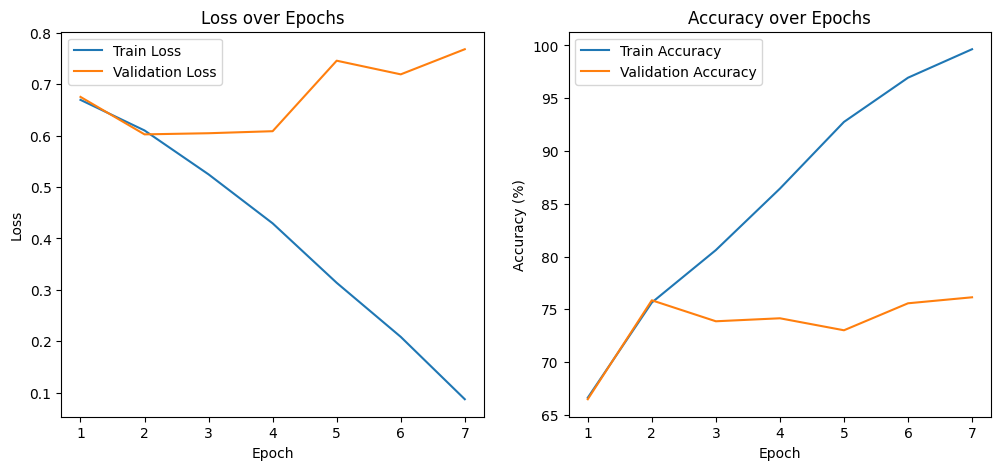

In [ ]:
siamese_model = SiameseNetwork()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
num_epochs = 15
optimizer_type = 'SGD'
lr = 0.01
patience = 5
start_time = time.time()
train_losses, train_accuracies, val_losses, val_accuracies, epoch = train(siamese_model, train_loader, val_loader, device,
                                                                    num_epochs=num_epochs, optimizer_type=optimizer_type,
                                                                      lr=lr, patience=patience)
end_time = time.time()

epochs = range(1, len(train_losses) + 1)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss over Epochs')

plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label='Train Accuracy')
plt.plot(epochs, val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.title('Accuracy over Epochs')
plt.show()


Test Loss: 0.6671, Test Accuracy: 72.90%


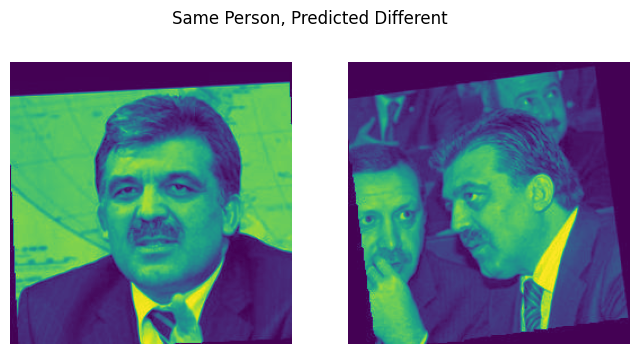

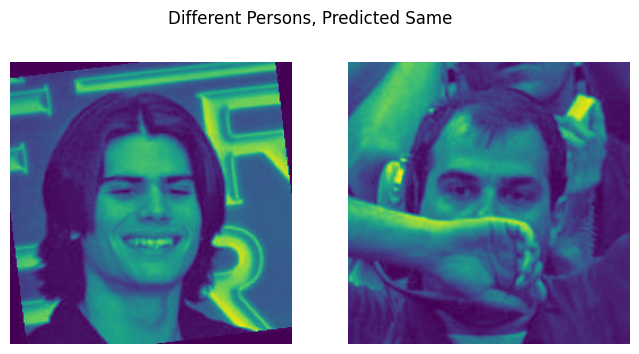

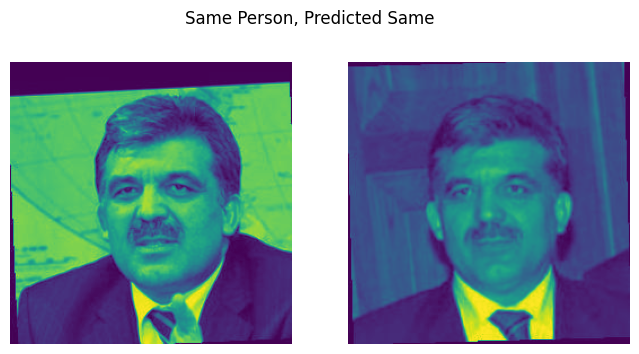

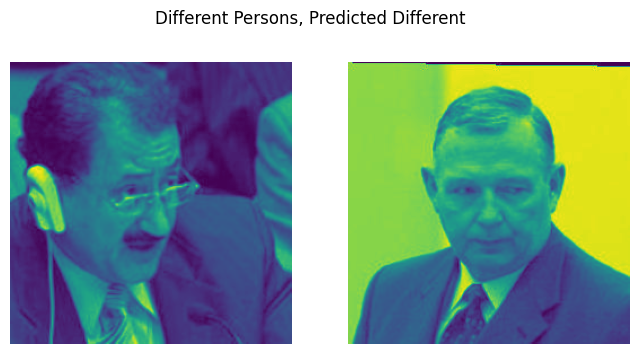

In [ ]:
def show_images(img1, img2, title, figsize=(8, 4)):
    fig, axes = plt.subplots(1, 2, figsize=figsize)
    axes[0].imshow(img1.permute(1, 2, 0).cpu())
    axes[0].axis('off')
    axes[1].imshow(img2.permute(1, 2, 0).cpu())
    axes[1].axis('off')
    fig.suptitle(title)
    plt.show()

def test_with_visualization(model, test_loader, device):
    model.eval()
    test_loss, test_correct, test_total = 0, 0, 0
    criterion = nn.BCELoss()
    
    same_person_wrong = None
    diff_person_wrong = None
    same_person_right = None
    diff_person_right = None

    with torch.no_grad():
        for data in test_loader:
            img1, img2, labels = data
            labels = labels.unsqueeze(1)
            img1, img2, labels = img1.to(device), img2.to(device), labels.to(device).float()
            
            outputs = model(img1, img2)
            loss = criterion(outputs, labels)
            test_loss += loss.item()

            predicted = outputs > 0.5
            test_correct += (predicted == labels).sum().item()
            test_total += labels.size(0)
            
            for i in range(len(labels)):
                if predicted[i] and not labels[i]:  # Different persons predicted as same
                    if diff_person_wrong is None:
                        diff_person_wrong = (img1[i], img2[i])
                elif not predicted[i] and labels[i]:  # Same person predicted as different
                    if same_person_wrong is None:
                        same_person_wrong = (img1[i], img2[i])
                elif predicted[i] and labels[i]:  # Same person predicted as same
                    if same_person_right is None:
                        same_person_right = (img1[i], img2[i])
                elif not predicted[i] and not labels[i]:  # Different persons predicted as different
                    if diff_person_right is None:
                        diff_person_right = (img1[i], img2[i])

    avg_test_loss = test_loss / len(test_loader)
    test_accuracy = 100 * test_correct / test_total
    print(f'Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%')

    if same_person_wrong is not None:
        show_images(same_person_wrong[0], same_person_wrong[1], 'Same Person, Predicted Different')
    if diff_person_wrong is not None:
        show_images(diff_person_wrong[0], diff_person_wrong[1], 'Different Persons, Predicted Same')
    if same_person_right is not None:
        show_images(same_person_right[0], same_person_right[1], 'Same Person, Predicted Same')
    if diff_person_right is not None:
        show_images(diff_person_right[0], diff_person_right[1], 'Different Persons, Predicted Different')
    return avg_test_loss, test_accuracy

avg_test_loss, test_accuracy = test_with_visualization(siamese_model, test_loader, device)

In [ ]:
results.append({
    'Num_Epochs': epoch,
    'batch_size': batch_size,
    'Optimizer': optimizer_type,
    'Learning_Rate': lr,
    'Time_Taken': end_time - start_time,
    'Train_Loss': sum(train_losses) / len(train_losses),
    'Train_Accuracy': sum(train_accuracies) / len(train_accuracies),
    'Val_Loss': sum(val_losses) / len(val_losses),
    'Val_Accuracy': sum(val_accuracies) / len(val_accuracies),
    'Test_Loss': avg_test_loss,
    'Test_Accuracy': test_accuracy,
})

# EX3

## bacth size 64

In [132]:
# Paths
train_dest_folder = '/home/tak/justice-tal//train'
test_dest_folder = '/home/tak/justice-tal/test'

# Split train pairs into training and validation sets
train_pairs, val_pairs = train_test_split(train_pairs, test_size=0.2, random_state=42)

# Define DataLoader for training, validation, and testing
batch_size = 64

print("Loading training data...")
train_loader = load_data(train_pairs, train_dest_folder, batch_size=batch_size, shuffle=True)

print("Loading validation data...")
val_loader = load_data(val_pairs, train_dest_folder, batch_size=batch_size, shuffle=False)

print("Loading testing data...")
test_loader = load_data(test_pairs, test_dest_folder, batch_size=batch_size, shuffle=False)

print("Data loaders created successfully.")


Loading training data...
Loading validation data...
Loading testing data...


Data loaders created successfully.


## network - batchnorm

In [133]:
class SiameseNetwork(nn.Module):
    """
    Siamese Network for one-shot learning on face recognition.

    This architecture is based on the model presented in the academic paper provided in the assignment.

    Network Architecture:
        - Convolutional layers with Batch Normalization and ReLU activation
        - MaxPooling layers for downsampling
        - Fully connected layers to transform the feature maps into a single vector
        - The network outputs the probability that the two input images belong to the same person

    Methods:
        forward(input1, input2): Performs the forward pass for a pair of input images.
        forward_through(x): Helper function to pass input through the CNN and FC layers.
    """
    def __init__(self):
        super(SiameseNetwork, self).__init__()

        # CNN architecture
        self.cnn = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=25, stride=1, padding=0),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, stride=2),
            nn.Conv2d(64, 128, kernel_size=18, stride=1, padding=0),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, stride=2),
            nn.Conv2d(128, 128, kernel_size=10, stride=1, padding=0),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, stride=2),
            nn.Conv2d(128, 256, kernel_size=10, stride=1, padding=0),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Flatten()
        )

        # Fully connected layers
        self.fc1 =  nn.Linear(256 * 10 * 10, 4096)
        self.fc2 = nn.Linear(4096, 1)

    def forward(self, input1, input2):
        """
        Forward pass for both inputs through the same CNN and FC layers.

        Args:
            input1 (torch.Tensor): The first input image.
            input2 (torch.Tensor): The second input image.

        Returns:
            torch.Tensor: The probability that the two input images are of the same person.
        """
        output1 = self.forward_through(input1)
        output2 = self.forward_through(input2)

        # Calculate the absolute difference between the feature representations
        diff_features = torch.abs(output1 - output2)
        output = self.fc2(diff_features)
        return torch.sigmoid(output)  # Apply sigmoid here to output a probability between 0 and 1

    def forward_through(self, x):
        """
        Helper function to propagate the input through the CNN and FC layers.

        Args:
            x (torch.Tensor): The input image.

        Returns:
            torch.Tensor: The output feature vector from the fully connected layer.
        """
        x = self.cnn(x)
        x = x.view(x.size(0), -1)  # Flatten the output to match the input needs of the FC layer
        x = self.fc1(x)  # Pass through the first fully connected layer
        return torch.sigmoid(x)


## train - SGD

In [134]:
from tqdm import tqdm
from sklearn.metrics import precision_recall_curve, roc_curve, f1_score

def find_best_threshold(y_true, y_scores):
    """
    Finds the best threshold based on F1 Score.

    Args:
        y_true: Ground truth labels (0 or 1).
        y_scores: Model predictions (probabilities).

    Returns:
        best_threshold: Threshold that maximizes the F1 Score.
    """
    thresholds = np.linspace(0, 1, 100)  # Generate thresholds from 0 to 1
    best_threshold = 0.5  # Default threshold
    best_accuracy = 0

    for threshold in thresholds:
        y_pred = (y_scores >= threshold).astype(int)  # Convert probabilities to binary predictions
        accuracy = (y_pred == y_true).mean()  # Compute accuracy
        
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_threshold = threshold

    return best_threshold


def train(model, train_loader, val_loader, device, num_epochs=10, optimizer_type='Adam', lr=0.001, patience=5):
    if optimizer_type == 'Adam':
        optimizer = optim.Adam(model.parameters(), lr=lr)
    elif optimizer_type == 'SGD':
        optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=1e-4)
    else:
        raise ValueError("Unsupported optimizer type")

    criterion = nn.BCELoss()

    scheduler = StepLR(optimizer, step_size=7, gamma=0.1)

    model.to(device)

    best_val_loss = float('inf')
    patience_counter = 0

    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    for epoch in range(num_epochs):
        model.train()
        train_loss, train_correct, train_total = 0, 0, 0

        for data in train_loader:
            img1, img2, labels = data
            img1, img2, labels = img1.to(device), img2.to(device), labels.to(device).float()
            labels = labels.unsqueeze(1)

            optimizer.zero_grad()
            outputs = model(img1, img2)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            predicted = outputs > find_best_threshold(labels.detach().cpu().numpy(), outputs.detach().cpu().numpy())
            train_correct += (predicted == labels).sum().item()
            train_total += labels.size(0)

        avg_train_loss = train_loss / len(train_loader)
        train_accuracy = 100 * train_correct / train_total
        train_losses.append(avg_train_loss)
        train_accuracies.append(train_accuracy)

        model.eval()
        val_loss, val_correct, val_total = 0, 0, 0
        with torch.no_grad():
            for data in val_loader:
                img1, img2, labels = data
                labels = labels.unsqueeze(1)
                img1, img2, labels = img1.to(device), img2.to(device), labels.to(device).float()

                outputs = model(img1, img2)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                predicted = outputs > find_best_threshold(labels.detach().cpu().numpy(), outputs.detach().cpu().numpy())
                val_correct += (predicted == labels).sum().item()
                val_total += labels.size(0)

        avg_val_loss = val_loss / len(val_loader)
        val_accuracy = 100 * val_correct / val_total
        val_losses.append(avg_val_loss)
        val_accuracies.append(val_accuracy)

        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Train Acc: {train_accuracy:.2f}%')
        print(f'Validation Loss: {avg_val_loss:.4f}, Validation Acc: {val_accuracy:.2f}%')

        # Learning rate scheduling
        scheduler.step()

        # Early stopping
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            patience_counter = 0
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print(f'Early stopping triggered after {epoch+1} epochs.')
            break

    return train_losses, train_accuracies, val_losses, val_accuracies, epoch+1

Epoch [1/15], Train Loss: 0.6878, Train Acc: 63.50%
Validation Loss: 0.6673, Validation Acc: 68.79%
Epoch [2/15], Train Loss: 0.6216, Train Acc: 77.35%
Validation Loss: 0.6293, Validation Acc: 72.70%
Epoch [3/15], Train Loss: 0.5256, Train Acc: 81.08%
Validation Loss: 0.5855, Validation Acc: 74.47%
Epoch [4/15], Train Loss: 0.4298, Train Acc: 88.01%
Validation Loss: 0.5661, Validation Acc: 75.53%
Epoch [5/15], Train Loss: 0.2951, Train Acc: 95.74%
Validation Loss: 0.5635, Validation Acc: 76.24%
Epoch [6/15], Train Loss: 0.1698, Train Acc: 99.29%
Validation Loss: 0.5765, Validation Acc: 76.24%
Epoch [7/15], Train Loss: 0.0863, Train Acc: 99.91%
Validation Loss: 0.6188, Validation Acc: 76.95%
Epoch [8/15], Train Loss: 0.0462, Train Acc: 100.00%
Validation Loss: 0.5918, Validation Acc: 78.37%
Epoch [9/15], Train Loss: 0.0403, Train Acc: 100.00%
Validation Loss: 0.6035, Validation Acc: 78.37%
Epoch [10/15], Train Loss: 0.0365, Train Acc: 100.00%
Validation Loss: 0.6021, Validation Acc: 78.

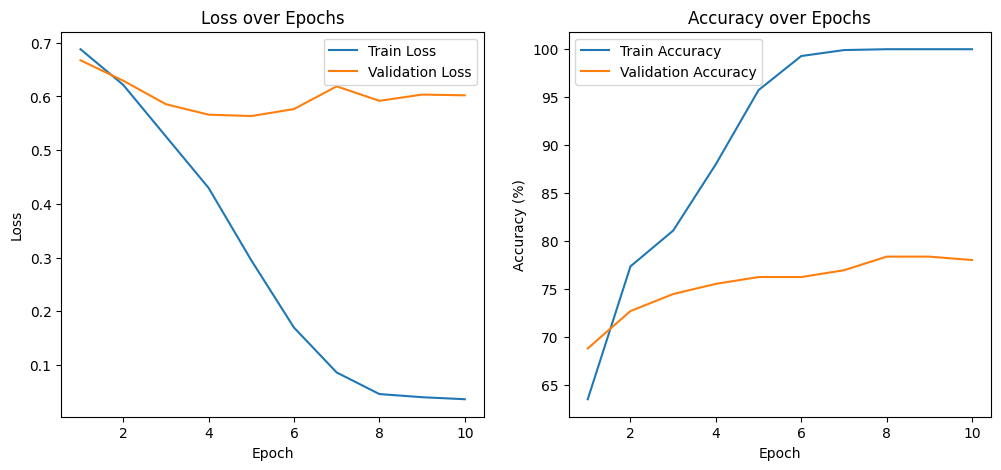

In [135]:
siamese_model = SiameseNetwork()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
num_epochs = 15
optimizer_type = 'SGD'
lr = 0.01
patience = 5
start_time = time.time()
train_losses, train_accuracies, val_losses, val_accuracies, epoch = train(siamese_model, train_loader, val_loader, device,
                                                                    num_epochs=num_epochs, optimizer_type=optimizer_type,
                                                                      lr=lr, patience=patience)
end_time = time.time()

epochs = range(1, len(train_losses) + 1)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss over Epochs')

plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label='Train Accuracy')
plt.plot(epochs, val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.title('Accuracy over Epochs')
plt.show()


Test Loss: 0.5975, Test Accuracy: 72.00%


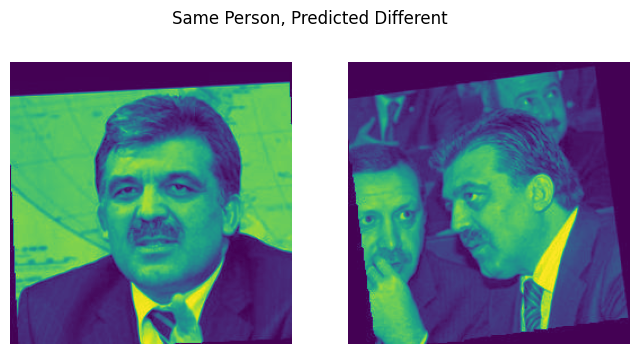

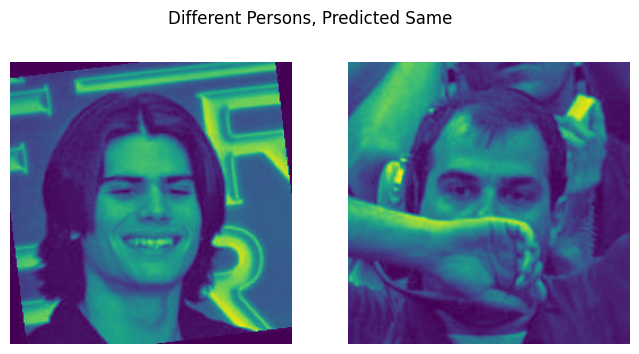

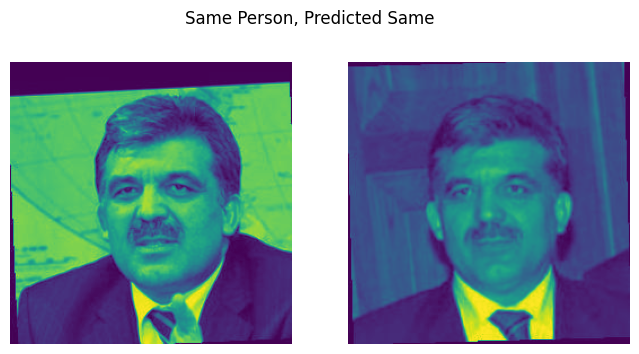

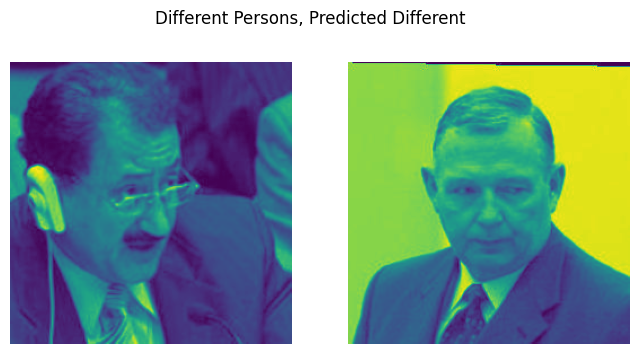

In [136]:
def show_images(img1, img2, title, figsize=(8, 4)):
    fig, axes = plt.subplots(1, 2, figsize=figsize)
    axes[0].imshow(img1.permute(1, 2, 0).cpu())
    axes[0].axis('off')
    axes[1].imshow(img2.permute(1, 2, 0).cpu())
    axes[1].axis('off')
    fig.suptitle(title)
    plt.show()

def test_with_visualization(model, test_loader, device):
    model.eval()
    test_loss, test_correct, test_total = 0, 0, 0
    criterion = nn.BCELoss()
    
    same_person_wrong = None
    diff_person_wrong = None
    same_person_right = None
    diff_person_right = None

    with torch.no_grad():
        for data in test_loader:
            img1, img2, labels = data
            labels = labels.unsqueeze(1)
            img1, img2, labels = img1.to(device), img2.to(device), labels.to(device).float()
            
            outputs = model(img1, img2)
            loss = criterion(outputs, labels)
            test_loss += loss.item()

            predicted = outputs > 0.5
            test_correct += (predicted == labels).sum().item()
            test_total += labels.size(0)
            
            for i in range(len(labels)):
                if predicted[i] and not labels[i]:  # Different persons predicted as same
                    if diff_person_wrong is None:
                        diff_person_wrong = (img1[i], img2[i])
                elif not predicted[i] and labels[i]:  # Same person predicted as different
                    if same_person_wrong is None:
                        same_person_wrong = (img1[i], img2[i])
                elif predicted[i] and labels[i]:  # Same person predicted as same
                    if same_person_right is None:
                        same_person_right = (img1[i], img2[i])
                elif not predicted[i] and not labels[i]:  # Different persons predicted as different
                    if diff_person_right is None:
                        diff_person_right = (img1[i], img2[i])

    avg_test_loss = test_loss / len(test_loader)
    test_accuracy = 100 * test_correct / test_total
    print(f'Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%')

    if same_person_wrong is not None:
        show_images(same_person_wrong[0], same_person_wrong[1], 'Same Person, Predicted Different')
    if diff_person_wrong is not None:
        show_images(diff_person_wrong[0], diff_person_wrong[1], 'Different Persons, Predicted Same')
    if same_person_right is not None:
        show_images(same_person_right[0], same_person_right[1], 'Same Person, Predicted Same')
    if diff_person_right is not None:
        show_images(diff_person_right[0], diff_person_right[1], 'Different Persons, Predicted Different')
    return avg_test_loss, test_accuracy

avg_test_loss, test_accuracy = test_with_visualization(siamese_model, test_loader, device)

In [137]:
results.append({
    'Num_Epochs': epoch,
    'batch_size': batch_size,
    'Optimizer': optimizer_type,
    'Learning_Rate': lr,
    'Time_Taken': end_time - start_time,
    'Train_Loss': sum(train_losses) / len(train_losses),
    'Train_Accuracy': sum(train_accuracies) / len(train_accuracies),
    'Val_Loss': sum(val_losses) / len(val_losses),
    'Val_Accuracy': sum(val_accuracies) / len(val_accuracies),
    'Test_Loss': avg_test_loss,
    'Test_Accuracy': test_accuracy,
})

# EX4

## bacth size 32

In [138]:
# Paths
train_dest_folder = '/home/tak/justice-tal//train'
test_dest_folder = '/home/tak/justice-tal/test'

# Split train pairs into training and validation sets
train_pairs, val_pairs = train_test_split(train_pairs, test_size=0.2, random_state=42)

# Define DataLoader for training, validation, and testing
batch_size = 32

print("Loading training data...")
train_loader = load_data(train_pairs, train_dest_folder, batch_size=batch_size, shuffle=True)

print("Loading validation data...")
val_loader = load_data(val_pairs, train_dest_folder, batch_size=batch_size, shuffle=False)

print("Loading testing data...")
test_loader = load_data(test_pairs, test_dest_folder, batch_size=batch_size, shuffle=False)

print("Data loaders created successfully.")


Loading training data...
Loading validation data...
Loading testing data...


Data loaders created successfully.


## network - batchnorm

In [139]:
class SiameseNetwork(nn.Module):
    """
    Siamese Network for one-shot learning on face recognition.

    This architecture is based on the model presented in the academic paper provided in the assignment.

    Network Architecture:
        - Convolutional layers with Batch Normalization and ReLU activation
        - MaxPooling layers for downsampling
        - Fully connected layers to transform the feature maps into a single vector
        - The network outputs the probability that the two input images belong to the same person

    Methods:
        forward(input1, input2): Performs the forward pass for a pair of input images.
        forward_through(x): Helper function to pass input through the CNN and FC layers.
    """
    def __init__(self):
        super(SiameseNetwork, self).__init__()

        # CNN architecture
        self.cnn = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=25, stride=1, padding=0),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, stride=2),
            nn.Conv2d(64, 128, kernel_size=18, stride=1, padding=0),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, stride=2),
            nn.Conv2d(128, 128, kernel_size=10, stride=1, padding=0),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, stride=2),
            nn.Conv2d(128, 256, kernel_size=10, stride=1, padding=0),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Flatten()
        )

        # Fully connected layers
        self.fc1 =  nn.Linear(256 * 10 * 10, 4096)


        self.fc2 = nn.Linear(4096, 1)

    def forward(self, input1, input2):
        """
        Forward pass for both inputs through the same CNN and FC layers.

        Args:
            input1 (torch.Tensor): The first input image.
            input2 (torch.Tensor): The second input image.

        Returns:
            torch.Tensor: The probability that the two input images are of the same person.
        """
        output1 = self.forward_through(input1)
        output2 = self.forward_through(input2)

        # Calculate the absolute difference between the feature representations
        diff_features = torch.abs(output1 - output2)
        output = self.fc2(diff_features)
        return torch.sigmoid(output)  # Apply sigmoid here to output a probability between 0 and 1

    def forward_through(self, x):
        """
        Helper function to propagate the input through the CNN and FC layers.

        Args:
            x (torch.Tensor): The input image.

        Returns:
            torch.Tensor: The output feature vector from the fully connected layer.
        """
        x = self.cnn(x)
        x = x.view(x.size(0), -1)  # Flatten the output to match the input needs of the FC layer
        x = self.fc1(x)  # Pass through the first fully connected layer
        return torch.sigmoid(x)


## train - Adam

In [140]:
from tqdm import tqdm
from sklearn.metrics import precision_recall_curve, roc_curve, f1_score

def find_best_threshold(y_true, y_scores):
    """
    Finds the best threshold based on F1 Score.

    Args:
        y_true: Ground truth labels (0 or 1).
        y_scores: Model predictions (probabilities).

    Returns:
        best_threshold: Threshold that maximizes the F1 Score.
    """
    thresholds = np.linspace(0, 1, 100)  # Generate thresholds from 0 to 1
    best_threshold = 0.5  # Default threshold
    best_accuracy = 0

    for threshold in thresholds:
        y_pred = (y_scores >= threshold).astype(int)  # Convert probabilities to binary predictions
        accuracy = (y_pred == y_true).mean()  # Compute accuracy
        
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_threshold = threshold

    return best_threshold


def train(model, train_loader, val_loader, device, num_epochs=10, optimizer_type='Adam', lr=0.001, patience=5):
    if optimizer_type == 'Adam':
        optimizer = optim.Adam(model.parameters(), lr=lr)
    elif optimizer_type == 'SGD':
        optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
    else:
        raise ValueError("Unsupported optimizer type")

    criterion = nn.BCELoss()

    scheduler = StepLR(optimizer, step_size=7, gamma=0.1)

    model.to(device)

    best_val_loss = float('inf')
    patience_counter = 0

    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    for epoch in range(num_epochs):
        model.train()
        train_loss, train_correct, train_total = 0, 0, 0

        for data in train_loader:
            img1, img2, labels = data
            img1, img2, labels = img1.to(device), img2.to(device), labels.to(device).float()
            labels = labels.unsqueeze(1)

            optimizer.zero_grad()
            outputs = model(img1, img2)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            predicted = outputs > find_best_threshold(labels.detach().cpu().numpy(), outputs.detach().cpu().numpy())
            train_correct += (predicted == labels).sum().item()
            train_total += labels.size(0)

        avg_train_loss = train_loss / len(train_loader)
        train_accuracy = 100 * train_correct / train_total
        train_losses.append(avg_train_loss)
        train_accuracies.append(train_accuracy)

        model.eval()
        val_loss, val_correct, val_total = 0, 0, 0
        with torch.no_grad():
            for data in val_loader:
                img1, img2, labels = data
                labels = labels.unsqueeze(1)
                img1, img2, labels = img1.to(device), img2.to(device), labels.to(device).float()

                outputs = model(img1, img2)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                predicted = outputs > find_best_threshold(labels.detach().cpu().numpy(), outputs.detach().cpu().numpy())
                val_correct += (predicted == labels).sum().item()
                val_total += labels.size(0)

        avg_val_loss = val_loss / len(val_loader)
        val_accuracy = 100 * val_correct / val_total
        val_losses.append(avg_val_loss)
        val_accuracies.append(val_accuracy)

        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Train Acc: {train_accuracy:.2f}%')
        print(f'Validation Loss: {avg_val_loss:.4f}, Validation Acc: {val_accuracy:.2f}%')

        # Learning rate scheduling
        scheduler.step()

        # Early stopping
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            patience_counter = 0
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print(f'Early stopping triggered after {epoch+1} epochs.')
            break

    return train_losses, train_accuracies, val_losses, val_accuracies, epoch+1

Epoch [1/15], Train Loss: 0.7740, Train Acc: 62.00%
Validation Loss: 0.7710, Validation Acc: 61.95%
Epoch [2/15], Train Loss: 0.7065, Train Acc: 64.56%
Validation Loss: 0.7371, Validation Acc: 65.49%
Epoch [3/15], Train Loss: 0.6966, Train Acc: 65.22%
Validation Loss: 0.7061, Validation Acc: 64.16%
Epoch [4/15], Train Loss: 0.7015, Train Acc: 65.89%
Validation Loss: 0.7940, Validation Acc: 66.37%
Epoch [5/15], Train Loss: 0.6935, Train Acc: 64.67%
Validation Loss: 0.6927, Validation Acc: 63.72%
Epoch [6/15], Train Loss: 0.6861, Train Acc: 66.00%
Validation Loss: 0.7982, Validation Acc: 66.37%
Epoch [7/15], Train Loss: 0.6842, Train Acc: 63.11%
Validation Loss: 0.6875, Validation Acc: 65.49%
Epoch [8/15], Train Loss: 0.6898, Train Acc: 65.33%
Validation Loss: 0.7259, Validation Acc: 68.58%
Epoch [9/15], Train Loss: 0.6828, Train Acc: 67.33%
Validation Loss: 0.7176, Validation Acc: 66.37%
Epoch [10/15], Train Loss: 0.6741, Train Acc: 66.44%
Validation Loss: 0.7261, Validation Acc: 68.58%

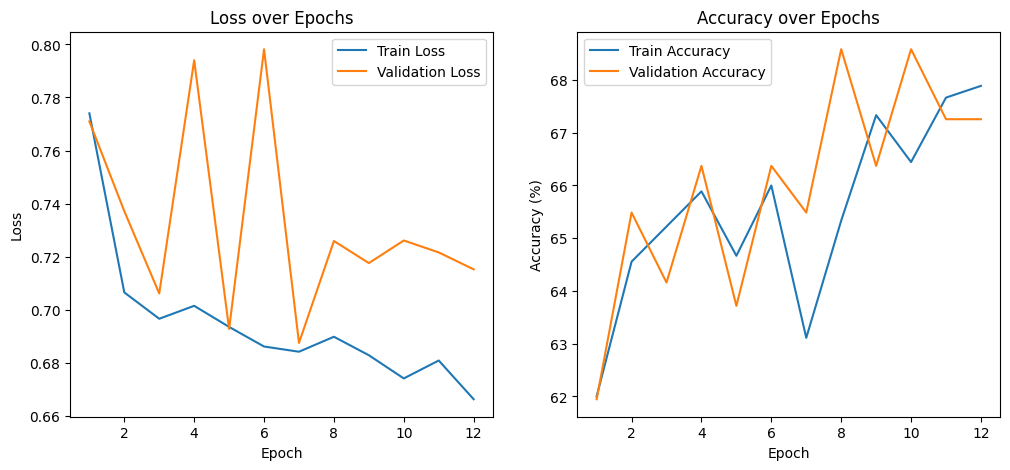

In [141]:
siamese_model = SiameseNetwork()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
num_epochs = 15
optimizer_type = 'Adam'
lr = 0.01
patience = 5
start_time = time.time()
train_losses, train_accuracies, val_losses, val_accuracies, epoch = train(siamese_model, train_loader, val_loader, device,
                                                                    num_epochs=num_epochs, optimizer_type=optimizer_type,
                                                                      lr=lr, patience=patience)
end_time = time.time()

epochs = range(1, len(train_losses) + 1)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss over Epochs')

plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label='Train Accuracy')
plt.plot(epochs, val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.title('Accuracy over Epochs')
plt.show()


Test Loss: 0.6876, Test Accuracy: 54.20%


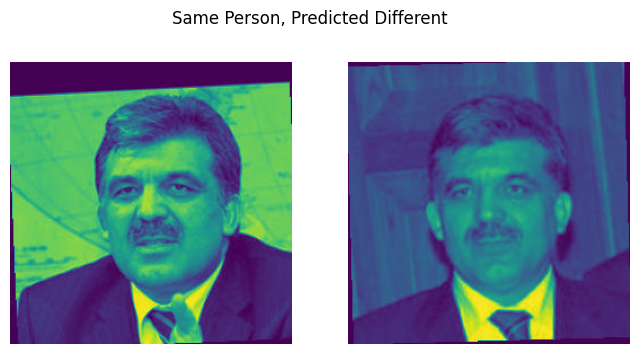

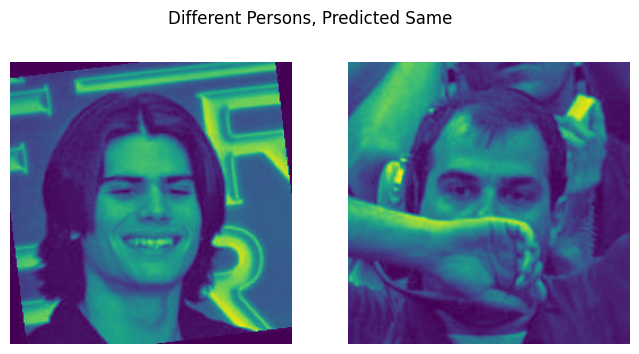

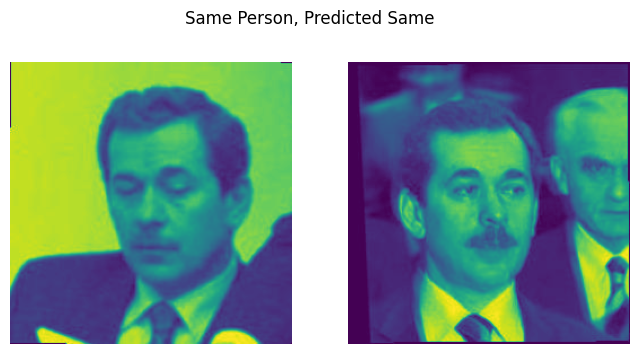

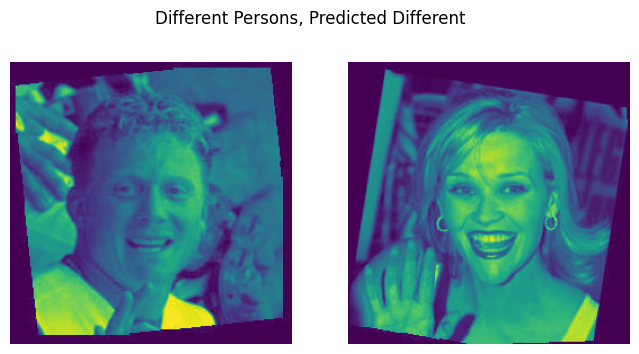

In [142]:
def show_images(img1, img2, title, figsize=(8, 4)):
    fig, axes = plt.subplots(1, 2, figsize=figsize)
    axes[0].imshow(img1.permute(1, 2, 0).cpu())
    axes[0].axis('off')
    axes[1].imshow(img2.permute(1, 2, 0).cpu())
    axes[1].axis('off')
    fig.suptitle(title)
    plt.show()

def test_with_visualization(model, test_loader, device):
    model.eval()
    test_loss, test_correct, test_total = 0, 0, 0
    criterion = nn.BCELoss()
    
    same_person_wrong = None
    diff_person_wrong = None
    same_person_right = None
    diff_person_right = None

    with torch.no_grad():
        for data in test_loader:
            img1, img2, labels = data
            labels = labels.unsqueeze(1)
            img1, img2, labels = img1.to(device), img2.to(device), labels.to(device).float()
            
            outputs = model(img1, img2)
            loss = criterion(outputs, labels)
            test_loss += loss.item()

            predicted = outputs > 0.5
            test_correct += (predicted == labels).sum().item()
            test_total += labels.size(0)
            
            for i in range(len(labels)):
                if predicted[i] and not labels[i]:  # Different persons predicted as same
                    if diff_person_wrong is None:
                        diff_person_wrong = (img1[i], img2[i])
                elif not predicted[i] and labels[i]:  # Same person predicted as different
                    if same_person_wrong is None:
                        same_person_wrong = (img1[i], img2[i])
                elif predicted[i] and labels[i]:  # Same person predicted as same
                    if same_person_right is None:
                        same_person_right = (img1[i], img2[i])
                elif not predicted[i] and not labels[i]:  # Different persons predicted as different
                    if diff_person_right is None:
                        diff_person_right = (img1[i], img2[i])

    avg_test_loss = test_loss / len(test_loader)
    test_accuracy = 100 * test_correct / test_total
    print(f'Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%')

    if same_person_wrong is not None:
        show_images(same_person_wrong[0], same_person_wrong[1], 'Same Person, Predicted Different')
    if diff_person_wrong is not None:
        show_images(diff_person_wrong[0], diff_person_wrong[1], 'Different Persons, Predicted Same')
    if same_person_right is not None:
        show_images(same_person_right[0], same_person_right[1], 'Same Person, Predicted Same')
    if diff_person_right is not None:
        show_images(diff_person_right[0], diff_person_right[1], 'Different Persons, Predicted Different')
    return avg_test_loss, test_accuracy

avg_test_loss, test_accuracy = test_with_visualization(siamese_model, test_loader, device)

In [143]:
results.append({
    'Num_Epochs': epoch,
    'batch_size': batch_size,
    'Optimizer': optimizer_type,
    'Learning_Rate': lr,
    'Time_Taken': end_time - start_time,
    'Train_Loss': sum(train_losses) / len(train_losses),
    'Train_Accuracy': sum(train_accuracies) / len(train_accuracies),
    'Val_Loss': sum(val_losses) / len(val_losses),
    'Val_Accuracy': sum(val_accuracies) / len(val_accuracies),
    'Test_Loss': avg_test_loss,
    'Test_Accuracy': test_accuracy,
})

# EX5

## bacth size 64

In [144]:
# Paths
train_dest_folder = '/home/tak/justice-tal//train'
test_dest_folder = '/home/tak/justice-tal/test'

# Split train pairs into training and validation sets
train_pairs, val_pairs = train_test_split(train_pairs, test_size=0.2, random_state=42)

# Define DataLoader for training, validation, and testing
batch_size = 64

print("Loading training data...")
train_loader = load_data(train_pairs, train_dest_folder, batch_size=batch_size, shuffle=True)

print("Loading validation data...")
val_loader = load_data(val_pairs, train_dest_folder, batch_size=batch_size, shuffle=False)

print("Loading testing data...")
test_loader = load_data(test_pairs, test_dest_folder, batch_size=batch_size, shuffle=False)

print("Data loaders created successfully.")


Loading training data...
Loading validation data...
Loading testing data...


Data loaders created successfully.


## network - batchnorm

In [145]:
class SiameseNetwork(nn.Module):
    """
    Siamese Network for one-shot learning on face recognition.

    This architecture is based on the model presented in the academic paper provided in the assignment.

    Network Architecture:
        - Convolutional layers with Batch Normalization and ReLU activation
        - MaxPooling layers for downsampling
        - Fully connected layers to transform the feature maps into a single vector
        - The network outputs the probability that the two input images belong to the same person

    Methods:
        forward(input1, input2): Performs the forward pass for a pair of input images.
        forward_through(x): Helper function to pass input through the CNN and FC layers.
    """
    def __init__(self):
        super(SiameseNetwork, self).__init__()

        # CNN architecture
        self.cnn = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=25, stride=1, padding=0),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, stride=2),
            nn.Conv2d(64, 128, kernel_size=18, stride=1, padding=0),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, stride=2),
            nn.Conv2d(128, 128, kernel_size=10, stride=1, padding=0),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, stride=2),
            nn.Conv2d(128, 256, kernel_size=10, stride=1, padding=0),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Flatten()
        )

        # Fully connected layers
        self.fc1 =  nn.Linear(256 * 10 * 10, 4096)


        self.fc2 = nn.Linear(4096, 1)

    def forward(self, input1, input2):
        """
        Forward pass for both inputs through the same CNN and FC layers.

        Args:
            input1 (torch.Tensor): The first input image.
            input2 (torch.Tensor): The second input image.

        Returns:
            torch.Tensor: The probability that the two input images are of the same person.
        """
        output1 = self.forward_through(input1)
        output2 = self.forward_through(input2)

        # Calculate the absolute difference between the feature representations
        diff_features = torch.abs(output1 - output2)
        output = self.fc2(diff_features)
        return torch.sigmoid(output)  # Apply sigmoid here to output a probability between 0 and 1

    def forward_through(self, x):
        """
        Helper function to propagate the input through the CNN and FC layers.

        Args:
            x (torch.Tensor): The input image.

        Returns:
            torch.Tensor: The output feature vector from the fully connected layer.
        """
        x = self.cnn(x)
        x = x.view(x.size(0), -1)  # Flatten the output to match the input needs of the FC layer
        x = self.fc1(x)  # Pass through the first fully connected layer
        return torch.sigmoid(x)


## train - Adam

In [146]:
from tqdm import tqdm
from sklearn.metrics import precision_recall_curve, roc_curve, f1_score

def find_best_threshold(y_true, y_scores):
    """
    Finds the best threshold based on F1 Score.

    Args:
        y_true: Ground truth labels (0 or 1).
        y_scores: Model predictions (probabilities).

    Returns:
        best_threshold: Threshold that maximizes the F1 Score.
    """
    thresholds = np.linspace(0, 1, 100)  # Generate thresholds from 0 to 1
    best_threshold = 0.5  # Default threshold
    best_accuracy = 0

    for threshold in thresholds:
        y_pred = (y_scores >= threshold).astype(int)  # Convert probabilities to binary predictions
        accuracy = (y_pred == y_true).mean()  # Compute accuracy
        
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_threshold = threshold

    return best_threshold


def train(model, train_loader, val_loader, device, num_epochs=10, optimizer_type='Adam', lr=0.001, patience=5):
    if optimizer_type == 'Adam':
        optimizer = optim.Adam(model.parameters(), lr=lr)
    elif optimizer_type == 'SGD':
        optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
    else:
        raise ValueError("Unsupported optimizer type")

    criterion = nn.BCELoss()

    scheduler = StepLR(optimizer, step_size=7, gamma=0.1)

    model.to(device)

    best_val_loss = float('inf')
    patience_counter = 0

    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    for epoch in range(num_epochs):
        model.train()
        train_loss, train_correct, train_total = 0, 0, 0

        for data in train_loader:
            img1, img2, labels = data
            img1, img2, labels = img1.to(device), img2.to(device), labels.to(device).float()
            labels = labels.unsqueeze(1)

            optimizer.zero_grad()
            outputs = model(img1, img2)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            predicted = outputs > find_best_threshold(labels.detach().cpu().numpy(), outputs.detach().cpu().numpy())
            train_correct += (predicted == labels).sum().item()
            train_total += labels.size(0)

        avg_train_loss = train_loss / len(train_loader)
        train_accuracy = 100 * train_correct / train_total
        train_losses.append(avg_train_loss)
        train_accuracies.append(train_accuracy)

        model.eval()
        val_loss, val_correct, val_total = 0, 0, 0
        with torch.no_grad():
            for data in val_loader:
                img1, img2, labels = data
                labels = labels.unsqueeze(1)
                img1, img2, labels = img1.to(device), img2.to(device), labels.to(device).float()

                outputs = model(img1, img2)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                predicted = outputs > find_best_threshold(labels.detach().cpu().numpy(), outputs.detach().cpu().numpy())
                val_correct += (predicted == labels).sum().item()
                val_total += labels.size(0)

        avg_val_loss = val_loss / len(val_loader)
        val_accuracy = 100 * val_correct / val_total
        val_losses.append(avg_val_loss)
        val_accuracies.append(val_accuracy)

        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Train Acc: {train_accuracy:.2f}%')
        print(f'Validation Loss: {avg_val_loss:.4f}, Validation Acc: {val_accuracy:.2f}%')

        # Learning rate scheduling
        scheduler.step()

        # Early stopping
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            patience_counter = 0
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print(f'Early stopping triggered after {epoch+1} epochs.')
            break

    return train_losses, train_accuracies, val_losses, val_accuracies, epoch+1

Epoch [1/15], Train Loss: 0.7861, Train Acc: 59.17%
Validation Loss: 0.6881, Validation Acc: 63.89%
Epoch [2/15], Train Loss: 0.7002, Train Acc: 61.94%
Validation Loss: 0.6914, Validation Acc: 63.89%
Epoch [3/15], Train Loss: 0.6738, Train Acc: 64.86%
Validation Loss: 0.7377, Validation Acc: 59.44%
Epoch [4/15], Train Loss: 0.6766, Train Acc: 64.44%
Validation Loss: 0.6922, Validation Acc: 59.44%
Epoch [5/15], Train Loss: 0.6803, Train Acc: 64.58%
Validation Loss: 0.7035, Validation Acc: 60.56%
Epoch [6/15], Train Loss: 0.6812, Train Acc: 64.44%
Validation Loss: 0.7376, Validation Acc: 59.44%
Early stopping triggered after 6 epochs.


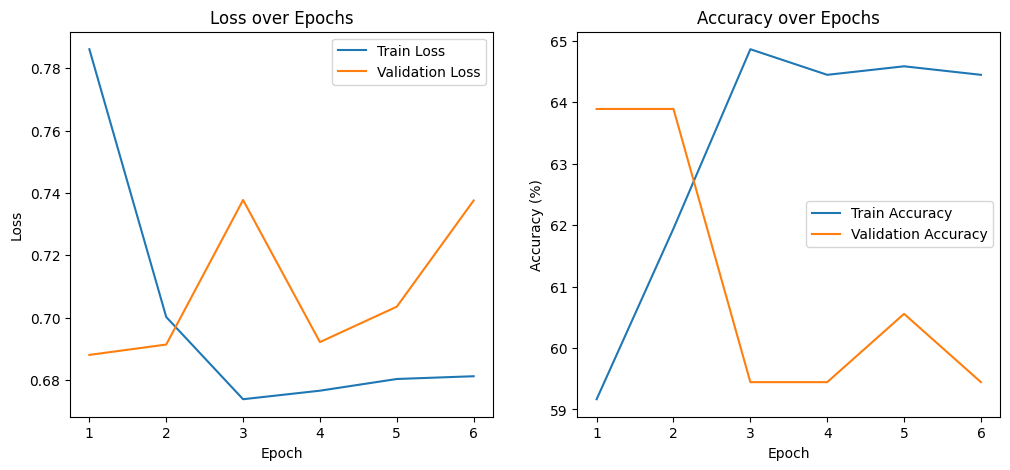

In [147]:
siamese_model = SiameseNetwork()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
num_epochs = 15
optimizer_type = 'Adam'
lr = 0.01
patience = 5
start_time = time.time()
train_losses, train_accuracies, val_losses, val_accuracies, epoch = train(siamese_model, train_loader, val_loader, device,
                                                                    num_epochs=num_epochs, optimizer_type=optimizer_type,
                                                                      lr=lr, patience=patience)
end_time = time.time()

epochs = range(1, len(train_losses) + 1)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss over Epochs')

plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label='Train Accuracy')
plt.plot(epochs, val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.title('Accuracy over Epochs')
plt.show()


Test Loss: 0.7255, Test Accuracy: 52.20%


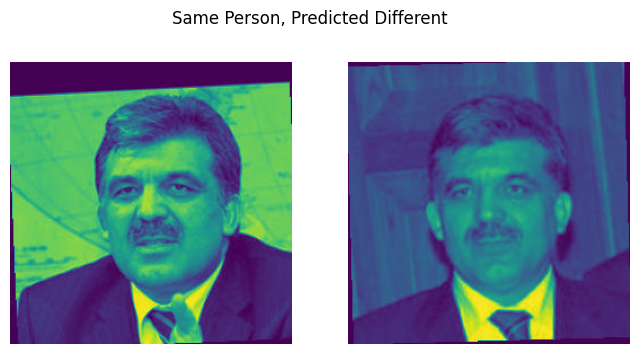

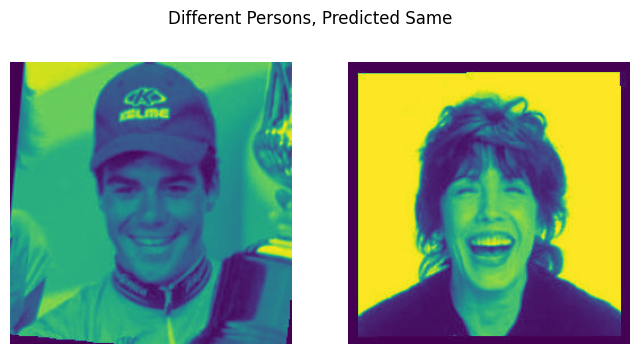

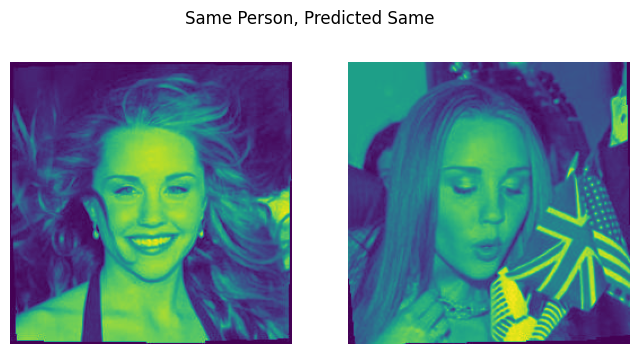

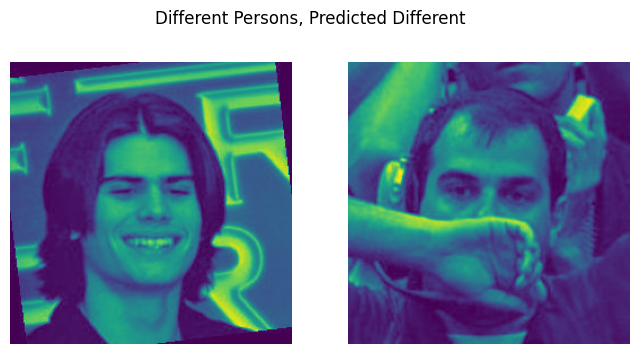

In [148]:
def show_images(img1, img2, title, figsize=(8, 4)):
    fig, axes = plt.subplots(1, 2, figsize=figsize)
    axes[0].imshow(img1.permute(1, 2, 0).cpu())
    axes[0].axis('off')
    axes[1].imshow(img2.permute(1, 2, 0).cpu())
    axes[1].axis('off')
    fig.suptitle(title)
    plt.show()

def test_with_visualization(model, test_loader, device):
    model.eval()
    test_loss, test_correct, test_total = 0, 0, 0
    criterion = nn.BCELoss()
    
    same_person_wrong = None
    diff_person_wrong = None
    same_person_right = None
    diff_person_right = None

    with torch.no_grad():
        for data in test_loader:
            img1, img2, labels = data
            labels = labels.unsqueeze(1)
            img1, img2, labels = img1.to(device), img2.to(device), labels.to(device).float()
            
            outputs = model(img1, img2)
            loss = criterion(outputs, labels)
            test_loss += loss.item()

            predicted = outputs > 0.5
            test_correct += (predicted == labels).sum().item()
            test_total += labels.size(0)
            
            for i in range(len(labels)):
                if predicted[i] and not labels[i]:  # Different persons predicted as same
                    if diff_person_wrong is None:
                        diff_person_wrong = (img1[i], img2[i])
                elif not predicted[i] and labels[i]:  # Same person predicted as different
                    if same_person_wrong is None:
                        same_person_wrong = (img1[i], img2[i])
                elif predicted[i] and labels[i]:  # Same person predicted as same
                    if same_person_right is None:
                        same_person_right = (img1[i], img2[i])
                elif not predicted[i] and not labels[i]:  # Different persons predicted as different
                    if diff_person_right is None:
                        diff_person_right = (img1[i], img2[i])

    avg_test_loss = test_loss / len(test_loader)
    test_accuracy = 100 * test_correct / test_total
    print(f'Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%')

    if same_person_wrong is not None:
        show_images(same_person_wrong[0], same_person_wrong[1], 'Same Person, Predicted Different')
    if diff_person_wrong is not None:
        show_images(diff_person_wrong[0], diff_person_wrong[1], 'Different Persons, Predicted Same')
    if same_person_right is not None:
        show_images(same_person_right[0], same_person_right[1], 'Same Person, Predicted Same')
    if diff_person_right is not None:
        show_images(diff_person_right[0], diff_person_right[1], 'Different Persons, Predicted Different')
    return avg_test_loss, test_accuracy

avg_test_loss, test_accuracy = test_with_visualization(siamese_model, test_loader, device)

In [149]:
results.append({
    'Num_Epochs': epoch,
    'batch_size': batch_size,
    'Optimizer': optimizer_type,
    'Learning_Rate': lr,
    'Time_Taken': end_time - start_time,
    'Train_Loss': sum(train_losses) / len(train_losses),
    'Train_Accuracy': sum(train_accuracies) / len(train_accuracies),
    'Val_Loss': sum(val_losses) / len(val_losses),
    'Val_Accuracy': sum(val_accuracies) / len(val_accuracies),
    'Test_Loss': avg_test_loss,
    'Test_Accuracy': test_accuracy,
})

# RESULTS

In [159]:
results_df = pd.DataFrame(results)
# round the results to 3 decimal places
results_df = results_df.round(3)
results_df.to_csv('results.csv', index=False)

# EX6 - with dropout

## bacth size 32

In [151]:
# Paths
train_dest_folder = '/home/tak/justice-tal//train'
test_dest_folder = '/home/tak/justice-tal/test'

# Split train pairs into training and validation sets
train_pairs, val_pairs = train_test_split(train_pairs, test_size=0.2, random_state=42)

# Define DataLoader for training, validation, and testing
batch_size = 32

print("Loading training data...")
train_loader = load_data(train_pairs, train_dest_folder, batch_size=batch_size, shuffle=True)

print("Loading validation data...")
val_loader = load_data(val_pairs, train_dest_folder, batch_size=batch_size, shuffle=False)

print("Loading testing data...")
test_loader = load_data(test_pairs, test_dest_folder, batch_size=batch_size, shuffle=False)

print("Data loaders created successfully.")


Loading training data...


Loading validation data...
Loading testing data...
Data loaders created successfully.


## network - batchnorm

In [152]:
class SiameseNetwork(nn.Module):
    """
    Siamese Network for one-shot learning on face recognition.

    This architecture is based on the model presented in the academic paper provided in the assignment.

    Network Architecture:
        - Convolutional layers with Batch Normalization and ReLU activation
        - MaxPooling layers for downsampling
        - Fully connected layers to transform the feature maps into a single vector
        - The network outputs the probability that the two input images belong to the same person

    Methods:
        forward(input1, input2): Performs the forward pass for a pair of input images.
        forward_through(x): Helper function to pass input through the CNN and FC layers.
    """
    def __init__(self):
        super(SiameseNetwork, self).__init__()

        # CNN architecture
        self.cnn = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=25, stride=1, padding=0),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, stride=2),
            nn.Dropout(0.4, inplace=False),
            nn.Conv2d(64, 128, kernel_size=18, stride=1, padding=0),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, stride=2),
            nn.Dropout(0.4, inplace=False),
            nn.Conv2d(128, 128, kernel_size=10, stride=1, padding=0),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, stride=2),
            nn.Dropout(0.4, inplace=False),
            nn.Conv2d(128, 256, kernel_size=10, stride=1, padding=0),
            nn.BatchNorm2d(256),
            nn.Dropout(0.4, inplace=False),
            nn.ReLU(inplace=True),
            nn.Flatten()
        )

        # Fully connected layers
        self.fc1 =  nn.Linear(256 * 10 * 10, 4096)
        self.fc2 = nn.Linear(4096, 1)

    def forward(self, input1, input2):
        """
        Forward pass for both inputs through the same CNN and FC layers.

        Args:
            input1 (torch.Tensor): The first input image.
            input2 (torch.Tensor): The second input image.

        Returns:
            torch.Tensor: The probability that the two input images are of the same person.
        """
        output1 = self.forward_through(input1)
        output2 = self.forward_through(input2)

        # Calculate the absolute difference between the feature representations
        diff_features = torch.abs(output1 - output2)
        output = self.fc2(diff_features)
        return torch.sigmoid(output)  # Apply sigmoid here to output a probability between 0 and 1

    def forward_through(self, x):
        """
        Helper function to propagate the input through the CNN and FC layers.

        Args:
            x (torch.Tensor): The input image.

        Returns:
            torch.Tensor: The output feature vector from the fully connected layer.
        """
        x = self.cnn(x)
        x = x.view(x.size(0), -1)  # Flatten the output to match the input needs of the FC layer
        x = self.fc1(x)  # Pass through the first fully connected layer
        return torch.sigmoid(x)


## train - SGD

In [153]:
from tqdm import tqdm
from sklearn.metrics import precision_recall_curve, roc_curve, f1_score

def find_best_threshold(y_true, y_scores):
    """
    Finds the best threshold based on F1 Score.

    Args:
        y_true: Ground truth labels (0 or 1).
        y_scores: Model predictions (probabilities).

    Returns:
        best_threshold: Threshold that maximizes the F1 Score.
    """
    thresholds = np.linspace(0, 1, 100)  # Generate thresholds from 0 to 1
    best_threshold = 0.5  # Default threshold
    best_accuracy = 0

    for threshold in thresholds:
        y_pred = (y_scores >= threshold).astype(int)  # Convert probabilities to binary predictions
        accuracy = (y_pred == y_true).mean()  # Compute accuracy
        
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_threshold = threshold

    return best_threshold


def train(model, train_loader, val_loader, device, num_epochs=10, optimizer_type='Adam', lr=0.001, patience=5):
    if optimizer_type == 'Adam':
        optimizer = optim.Adam(model.parameters(), lr=lr)
    elif optimizer_type == 'SGD':
        optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=1e-4)
    else:
        raise ValueError("Unsupported optimizer type")

    criterion = nn.BCELoss()

    scheduler = StepLR(optimizer, step_size=7, gamma=0.1)

    model.to(device)

    best_val_loss = float('inf')
    patience_counter = 0

    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    for epoch in range(num_epochs):
        model.train()
        train_loss, train_correct, train_total = 0, 0, 0

        for data in train_loader:
            img1, img2, labels = data
            img1, img2, labels = img1.to(device), img2.to(device), labels.to(device).float()
            labels = labels.unsqueeze(1)

            optimizer.zero_grad()
            outputs = model(img1, img2)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            predicted = outputs > find_best_threshold(labels.detach().cpu().numpy(), outputs.detach().cpu().numpy())
            train_correct += (predicted == labels).sum().item()
            train_total += labels.size(0)

        avg_train_loss = train_loss / len(train_loader)
        train_accuracy = 100 * train_correct / train_total
        train_losses.append(avg_train_loss)
        train_accuracies.append(train_accuracy)

        model.eval()
        val_loss, val_correct, val_total = 0, 0, 0
        with torch.no_grad():
            for data in val_loader:
                img1, img2, labels = data
                labels = labels.unsqueeze(1)
                img1, img2, labels = img1.to(device), img2.to(device), labels.to(device).float()

                outputs = model(img1, img2)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                predicted = outputs > find_best_threshold(labels.detach().cpu().numpy(), outputs.detach().cpu().numpy())
                val_correct += (predicted == labels).sum().item()
                val_total += labels.size(0)

        avg_val_loss = val_loss / len(val_loader)
        val_accuracy = 100 * val_correct / val_total
        val_losses.append(avg_val_loss)
        val_accuracies.append(val_accuracy)

        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Train Acc: {train_accuracy:.2f}%')
        print(f'Validation Loss: {avg_val_loss:.4f}, Validation Acc: {val_accuracy:.2f}%')

        # Learning rate scheduling
        scheduler.step()

        # Early stopping
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            patience_counter = 0
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print(f'Early stopping triggered after {epoch+1} epochs.')
            break

    return train_losses, train_accuracies, val_losses, val_accuracies, epoch+1

Epoch [1/15], Train Loss: 0.7055, Train Acc: 61.28%
Validation Loss: 0.7012, Validation Acc: 59.03%
Epoch [2/15], Train Loss: 0.6939, Train Acc: 67.53%
Validation Loss: 0.6894, Validation Acc: 61.81%
Epoch [3/15], Train Loss: 0.6632, Train Acc: 68.75%
Validation Loss: 0.7403, Validation Acc: 63.19%
Epoch [4/15], Train Loss: 0.6275, Train Acc: 73.26%
Validation Loss: 0.7082, Validation Acc: 61.81%
Epoch [5/15], Train Loss: 0.5670, Train Acc: 78.30%
Validation Loss: 0.7108, Validation Acc: 62.50%
Epoch [6/15], Train Loss: 0.5526, Train Acc: 77.95%
Validation Loss: 0.7158, Validation Acc: 65.28%
Epoch [7/15], Train Loss: 0.5291, Train Acc: 80.21%
Validation Loss: 0.7360, Validation Acc: 63.89%
Early stopping triggered after 7 epochs.


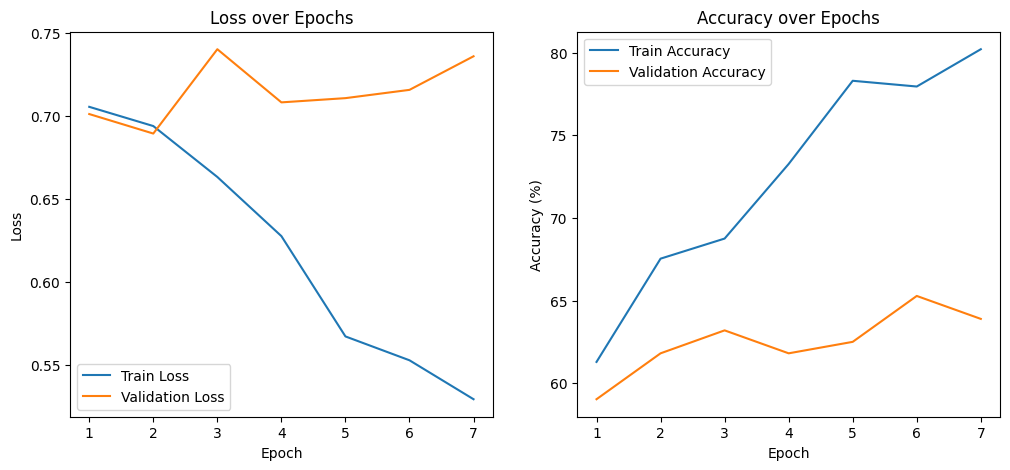

In [154]:
siamese_model = SiameseNetwork()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
num_epochs = 15
optimizer_type = 'SGD'
lr = 0.01
patience = 5
start_time = time.time()
train_losses, train_accuracies, val_losses, val_accuracies, epoch = train(siamese_model, train_loader, val_loader, device,
                                                                    num_epochs=num_epochs, optimizer_type=optimizer_type,
                                                                      lr=lr, patience=patience)
end_time = time.time()

epochs = range(1, len(train_losses) + 1)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss over Epochs')

plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label='Train Accuracy')
plt.plot(epochs, val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.title('Accuracy over Epochs')
plt.show()


Test Loss: 0.6758, Test Accuracy: 59.00%


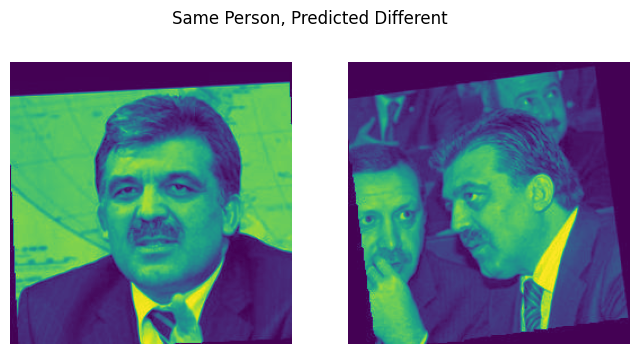

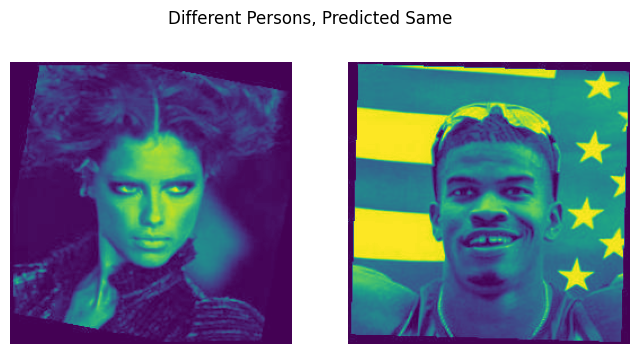

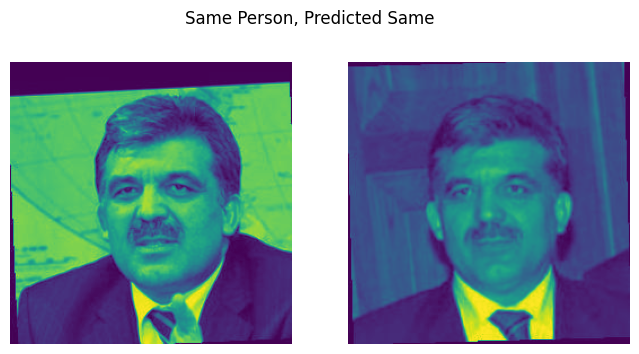

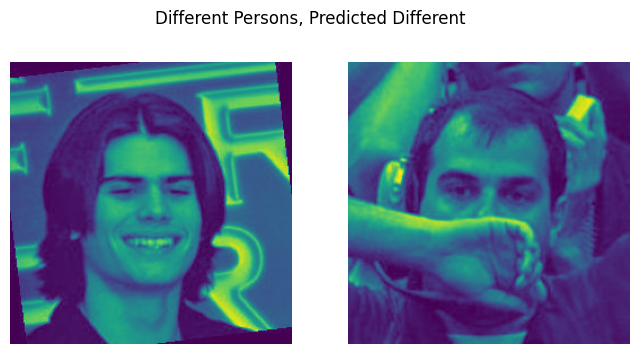

In [155]:
def show_images(img1, img2, title, figsize=(8, 4)):
    fig, axes = plt.subplots(1, 2, figsize=figsize)
    axes[0].imshow(img1.permute(1, 2, 0).cpu())
    axes[0].axis('off')
    axes[1].imshow(img2.permute(1, 2, 0).cpu())
    axes[1].axis('off')
    fig.suptitle(title)
    plt.show()

def test_with_visualization(model, test_loader, device):
    model.eval()
    test_loss, test_correct, test_total = 0, 0, 0
    criterion = nn.BCELoss()
    
    same_person_wrong = None
    diff_person_wrong = None
    same_person_right = None
    diff_person_right = None

    with torch.no_grad():
        for data in test_loader:
            img1, img2, labels = data
            labels = labels.unsqueeze(1)
            img1, img2, labels = img1.to(device), img2.to(device), labels.to(device).float()
            
            outputs = model(img1, img2)
            loss = criterion(outputs, labels)
            test_loss += loss.item()

            predicted = outputs > 0.5
            test_correct += (predicted == labels).sum().item()
            test_total += labels.size(0)
            
            for i in range(len(labels)):
                if predicted[i] and not labels[i]:  # Different persons predicted as same
                    if diff_person_wrong is None:
                        diff_person_wrong = (img1[i], img2[i])
                elif not predicted[i] and labels[i]:  # Same person predicted as different
                    if same_person_wrong is None:
                        same_person_wrong = (img1[i], img2[i])
                elif predicted[i] and labels[i]:  # Same person predicted as same
                    if same_person_right is None:
                        same_person_right = (img1[i], img2[i])
                elif not predicted[i] and not labels[i]:  # Different persons predicted as different
                    if diff_person_right is None:
                        diff_person_right = (img1[i], img2[i])

    avg_test_loss = test_loss / len(test_loader)
    test_accuracy = 100 * test_correct / test_total
    print(f'Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%')

    if same_person_wrong is not None:
        show_images(same_person_wrong[0], same_person_wrong[1], 'Same Person, Predicted Different')
    if diff_person_wrong is not None:
        show_images(diff_person_wrong[0], diff_person_wrong[1], 'Different Persons, Predicted Same')
    if same_person_right is not None:
        show_images(same_person_right[0], same_person_right[1], 'Same Person, Predicted Same')
    if diff_person_right is not None:
        show_images(diff_person_right[0], diff_person_right[1], 'Different Persons, Predicted Different')
    return avg_test_loss, test_accuracy

avg_test_loss, test_accuracy = test_with_visualization(siamese_model, test_loader, device)

In [156]:
results.append({
    'Num_Epochs': epoch,
    'batch_size': batch_size,
    'Optimizer': optimizer_type,
    'Learning_Rate': lr,
    'Time_Taken': end_time - start_time,
    'Train_Loss': sum(train_losses) / len(train_losses),
    'Train_Accuracy': sum(train_accuracies) / len(train_accuracies),
    'Val_Loss': sum(val_losses) / len(val_losses),
    'Val_Accuracy': sum(val_accuracies) / len(val_accuracies),
    'Test_Loss': avg_test_loss,
    'Test_Accuracy': test_accuracy,
})